In [75]:
import pandas as pd
import seaborn as sbn
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score, recall_score, make_scorer # precision: ketika benar, maka berapa persentase benar. recall: banyak data yang kena

In [76]:
df = pd.read_csv("ds_salaries.csv")
"""
Beberapa Notes untuk Kolom dataset tersebut adalah: 
1. work_year: Tahun dimana gajinya telah diberikan
2. experience_level: level experience / pengalaman dalam bidang pekerjaan
    field_value: {
        EN: Entry level                 1
        MI: Junior Mid Level            2
        SE: Intermediate Senior Level   3
        EX: Expert Executive Level      4
    }
3. employement_type: Tipe pekerja
    field_value: {
        PT: kerja paruh waktu           4
        FT: kerja fulltime              3
        CT: contract                    2
        FL: Freelance                   1
}
4. job_title: Job Title
5. salary: nilai gaji
6. salary_currency: nilai gaji tersebut dalam mata uang apa
7. salary_in_usd: gaji jika di ubah menjadi mata uang dollar
8. employee_residence: lokasi asal dari pekerja
9. remote_ratio: rasio pekerja bekerja secara jarak jauh
10. company_location: lokasi perusahaan pekerja
11. company_size: ukuran dari perusahaan berdasarkan dari jumlah pekerja di sana
    field_value{
        S: small (x<50),
        M: medium (50<=x<250),
        L: large (x>250),
}
"""


df = pd.read_csv("ds_salaries.csv")
df

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,1
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,1
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,1
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,1
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M,1
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M,1
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M,1
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M,1


Menghapus Outlier

In [77]:

q1 = df["salary_in_usd"].quantile(0.25) # Quartile 1
q3 = df["salary_in_usd"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary_in_usd"])):
    if hi_lim < df["salary_in_usd"][i]:
        df = df.drop([i])

df = df.reset_index()

q1 = df["salary"].quantile(0.25) # Quartile 1
q3 = df["salary"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary"])):
    if hi_lim < df["salary"][i]:
        df = df.drop([i])
df = df.reset_index()

df["company_size"] = df["company_size"].apply(lambda x: 1 if x == "S" else x)
df["company_size"] = df["company_size"].apply(lambda x: 2 if x == "M" else x)
df["company_size"] = df["company_size"].apply(lambda x: 3 if x == "L" else x)



df["experience_level"] = df["experience_level"].apply(lambda x: 1 if x == "EN" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 2 if x == "MI" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 3 if x == "SE" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 4 if x == "EX" else x)

df["employment_type"] = df["employment_type"].apply(lambda x: 4 if x == "FT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 3 if x == "PT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 2 if x == "CT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 1 if x == "FL" else x)

-68185.0, 280911.0
-65002.5, 295001.5


<Axes: >

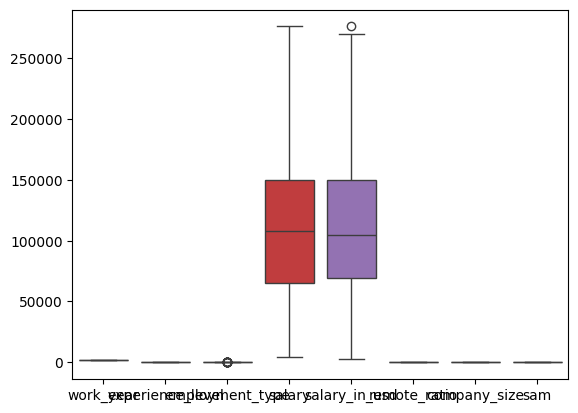

In [78]:
df = df.drop(columns=["level_0", "index", "Unnamed: 0"])
sbn.boxplot(data=df)

<Axes: xlabel='experience_level', ylabel='salary_in_usd'>

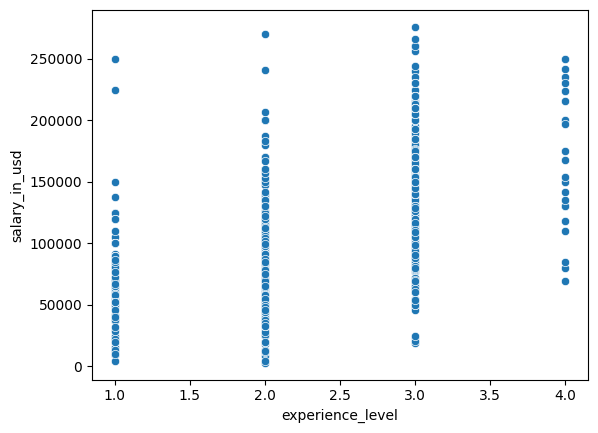

In [79]:
sbn.scatterplot(data=df, y= df["salary_in_usd"], x=df["experience_level"])

<Axes: xlabel='remote_ratio', ylabel='salary_in_usd'>

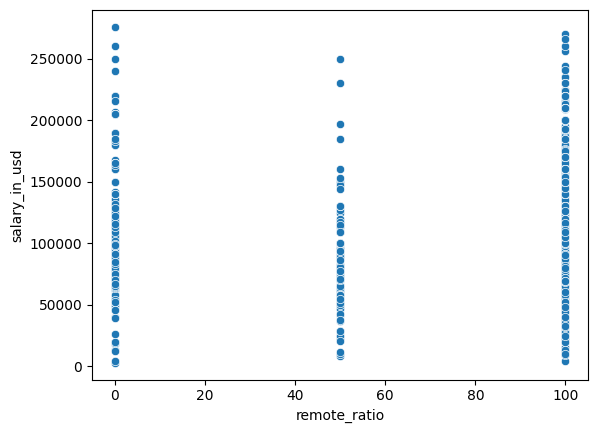

In [80]:
sbn.scatterplot(data=df, y= df["salary_in_usd"], x=df["remote_ratio"])


In [81]:
df.reset_index()

,index,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,0,2020,2,4,Data Scientist,70000,EUR,79833,DE,0,DE,3,1
1,1,2020,3,4,Machine Learning Scientist,260000,USD,260000,JP,0,JP,1,1
2,2,2020,3,4,Big Data Engineer,85000,GBP,109024,GB,50,GB,2,1
3,3,2020,2,4,Product Data Analyst,20000,USD,20000,HN,0,HN,1,1
4,4,2020,3,4,Machine Learning Engineer,150000,USD,150000,US,50,US,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,556,2022,3,4,Data Engineer,154000,USD,154000,US,100,US,2,1
557,557,2022,3,4,Data Engineer,126000,USD,126000,US,100,US,2,1
558,558,2022,3,4,Data Analyst,129000,USD,129000,US,0,US,2,1
559,559,2022,3,4,Data Analyst,150000,USD,150000,US,100,US,2,1


In [82]:
df.describe()

,work_year,experience_level,employment_type,salary,salary_in_usd,remote_ratio,company_size,sam
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.0
mean,2021.447415,2.422460,3.948307,112440.358289,111965.424242,71.568627,2.180036,1.0
std,0.679678,0.768669,0.325963,58419.459966,56881.438715,40.730377,0.636419,0.0
min,2020.000000,1.000000,1.000000,4000.000000,2859.000000,0.000000,1.000000,1.0
25%,2021.000000,2.000000,4.000000,65000.000000,69336.000000,50.000000,2.000000,1.0
50%,2022.000000,3.000000,4.000000,108000.000000,105000.000000,100.000000,2.000000,1.0
75%,2022.000000,3.000000,4.000000,150075.000000,150000.000000,100.000000,3.000000,1.0
max,2022.000000,4.000000,4.000000,276000.000000,276000.000000,100.000000,3.000000,1.0


In [83]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,2020,2,4,Data Scientist,70000,EUR,79833,DE,0,DE,3,1
1,2020,3,4,Machine Learning Scientist,260000,USD,260000,JP,0,JP,1,1
2,2020,3,4,Big Data Engineer,85000,GBP,109024,GB,50,GB,2,1
3,2020,2,4,Product Data Analyst,20000,USD,20000,HN,0,HN,1,1
4,2020,3,4,Machine Learning Engineer,150000,USD,150000,US,50,US,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
556,2022,3,4,Data Engineer,154000,USD,154000,US,100,US,2,1
557,2022,3,4,Data Engineer,126000,USD,126000,US,100,US,2,1
558,2022,3,4,Data Analyst,129000,USD,129000,US,0,US,2,1
559,2022,3,4,Data Analyst,150000,USD,150000,US,100,US,2,1


# Memisah data Untuk Train dan Test
1. Bentuk pandas DataFrame

In [84]:
def ratio_split(nil, data):
    """Masukkan Nilai dalam bentuk puluhan, misal: 70"""
    for i in data:
        nilai = len(data[i])
        return round(nilai * (nil/100))
data_column = df.columns
print(data_column)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'sam'],
      dtype='object')


In [85]:
def split_data(data, ratsplit:int, kolom) -> list:
    looping = 0
    looping_index = []
    test_index = []
    train_index = []
    test = []
    train = []
    for i in data:
        for j in range(len(data[i])):
            while True:
                randomval = random.randint(0, len(data[i])- 1)
                if randomval not in looping_index:
                    if looping <= ratsplit:
                        train_index.append(randomval)
                        looping_index.append(randomval)
                        looping += 1
                        break
                    else:
                        test_index.append(randomval)
                        looping_index.append(randomval)
                        looping += 1
                        break
                else:
                    continue
        break
    print(train_index)
    print(test_index)
    for i in train_index:
        duta = []
        for j in data:
            duta.append(data[j][i])
        train.append(duta)
    
    for i in test_index:
        duta = []
        for j in data:
            duta.append(data[j][i])
        test.append(duta)
    
    train = pd.DataFrame(train, columns=kolom)
    test = pd.DataFrame(test, columns=kolom)

    return train, test

In [86]:
ratsplit = ratio_split(70, df)
training, testing = split_data(df, ratsplit, data_column)
print(len(training), len(testing))

[14, 129, 541, 454, 524, 219, 125, 249, 2, 342, 415, 397, 68, 322, 290, 269, 239, 503, 366, 89, 431, 313, 148, 460, 530, 205, 554, 436, 446, 122, 324, 521, 351, 439, 110, 155, 369, 95, 270, 332, 348, 365, 4, 197, 556, 189, 374, 440, 33, 447, 73, 496, 143, 251, 388, 497, 404, 147, 113, 395, 163, 233, 222, 248, 416, 381, 53, 487, 282, 12, 506, 261, 516, 337, 472, 204, 19, 486, 400, 132, 433, 362, 237, 266, 300, 50, 341, 315, 280, 551, 128, 418, 150, 559, 509, 116, 495, 76, 180, 558, 371, 218, 277, 185, 529, 492, 172, 10, 379, 22, 232, 44, 227, 61, 234, 482, 74, 48, 238, 119, 299, 410, 123, 47, 426, 81, 136, 411, 373, 108, 193, 485, 463, 170, 275, 101, 480, 72, 176, 493, 276, 120, 331, 481, 461, 479, 88, 1, 271, 536, 16, 169, 364, 137, 368, 518, 209, 267, 513, 311, 252, 59, 18, 432, 401, 250, 240, 306, 389, 42, 27, 515, 312, 235, 145, 295, 82, 499, 91, 58, 43, 328, 542, 264, 96, 538, 531, 428, 393, 429, 201, 557, 168, 52, 334, 346, 109, 375, 500, 489, 434, 37, 532, 335, 54, 286, 157, 32, 

In [87]:
training

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,2020,3,4,Big Data Engineer,100000,EUR,114047,PL,100,GB,1,1
1,2021,2,4,Data Scientist,150000,USD,150000,US,100,US,2,1
2,2022,3,4,Data Scientist,140000,USD,140000,US,100,US,2,1
3,2022,3,4,Research Scientist,85000,EUR,93427,FR,50,FR,3,1
4,2022,3,4,Data Scientist,210000,USD,210000,US,100,US,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
389,2022,3,4,Data Scientist,180000,USD,180000,US,0,US,3,1
390,2022,3,4,Data Engineer,130000,USD,130000,US,100,US,2,1
391,2022,3,4,Data Analyst,60000,USD,60000,US,100,US,2,1
392,2020,2,4,BI Data Analyst,98000,USD,98000,US,0,US,2,1


In [88]:
testing

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,2022,3,4,Data Engineer,50000,GBP,65438,GB,0,GB,2,1
1,2022,2,4,Data Scientist,50000,GBP,65438,GB,0,GB,2,1
2,2022,1,4,ML Engineer,20000,EUR,21983,PT,100,PT,3,1
3,2021,2,4,Data Engineer,4000,USD,4000,IR,100,IR,2,1
4,2021,1,4,Machine Learning Engineer,81000,USD,81000,US,50,US,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
162,2021,2,4,Big Data Engineer,60000,USD,60000,ES,50,RO,2,1
163,2021,2,4,Data Analyst,90000,USD,90000,US,100,US,2,1
164,2022,2,4,Data Engineer,60000,GBP,78526,GB,0,GB,2,1
165,2022,2,4,Machine Learning Scientist,153000,USD,153000,US,50,US,2,1


2. Bentuk  Np. Array

# Implementasi ke dalam Machine Learning
1. Model Random Forest

In [89]:
x = df.drop(columns=["job_title", "salary", "salary_currency", "employee_residence", "company_location", "salary_in_usd", "work_year", "sam"]).values
y = df["salary_in_usd"]
print(f"x: {x.shape}, y: {y.shape}")
print(x)
print(y)

x: (561, 4), y: (561,)
[[  2   4   0   3]
 [  3   4   0   1]
 [  3   4  50   2]
 ...
 [  3   4   0   2]
 [  3   4 100   2]
 [  2   4 100   3]]
0       79833
1      260000
2      109024
3       20000
4      150000
        ...  
556    154000
557    126000
558    129000
559    150000
560    200000
Name: salary_in_usd, Length: 561, dtype: int64


In [90]:
pipa = Pipeline([
    ("scale", StandardScaler()),
    ("model", LogisticRegression())
])
pipa.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()), ('model', LogisticRegression())],
 'verbose': False,
 'scale': StandardScaler(),
 'model': LogisticRegression(),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'deprecated',
 'model__n_jobs': None,
 'model__penalty': 'l2',
 'model__random_state': None,
 'model__solver': 'lbfgs',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [91]:
moduel = GridSearchCV(
    estimator=pipa,
    param_grid={"model__verbose": [0,1,2]},
    cv=4,
    n_jobs=-1
)

In [92]:
moduel.fit(x,y)

c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1, param_grid={'model__verbose': [0, 1, 2]})

In [93]:
pd.DataFrame(moduel.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__verbose,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124528,0.012232,0.003678,0.002275,0,{'model__verbose': 0},0.042553,0.021429,0.021429,0.021429,0.02671,0.009147,1
1,0.121468,0.014846,0.004073,0.002759,1,{'model__verbose': 1},0.042553,0.021429,0.021429,0.021429,0.02671,0.009147,1
2,0.141703,0.012513,0.000938,0.000963,2,{'model__verbose': 2},0.042553,0.021429,0.021429,0.021429,0.02671,0.009147,1


In [94]:
xpred = moduel.predict(x)
print(xpred)

[140400 120000 120000  20000 150000 100000 120000 200000 120000  20000
  58000 200000 200000 150000 120000 100000 150000 120000 140400 100000
 100000 150000  90000 100000 200000 150000 150000 200000 100000  90000
  90000  90000 150000 120000 200000 150000 100000  90000 200000 200000
 150000 100000 100000  60000 150000 100000 100000 150000 100000 200000
 100000  20000 120000  90000  20000 150000  90000 120000 120000 120000
 100000 200000 200000 150000 100000 100000 100000 200000 200000 150000
  90000 200000 200000 100000 200000 200000 120000 200000  90000 140400
 150000 100000 100000  90000 140400 200000 140400 140400 150000 200000
 120000 150000 150000 150000 120000 100000 200000 100000 200000 100000
  90000 200000 120000 150000 100000 110037 100000 200000 120000  90000
  90000 100000 100000 150000  20000 100000 140400 100000 200000 140400
 140400  90000 200000 120000 120000 200000 200000 120000 120000 100000
 200000 100000 200000 150000 100000 150000  90000 150000 205300 150000
 10000

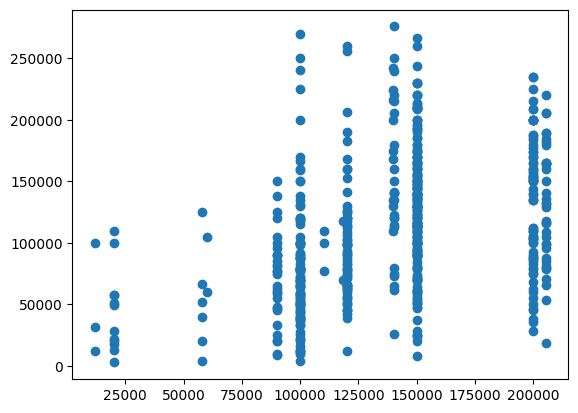

In [95]:
plt.scatter(xpred, y)
plt.show()